# Présentation de la quantization par Octo

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import copy
import sklearn.metrics
import os
import matplotlib.pyplot as plt

# set path the folder before
os.chdir("/Users/camille.hascoet/Documents/greenai/src/hale/clean/")

from green_ai.datasets import (
    make_train_test_loader,
    make_validation_loader,
)

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from typing import Tuple, List

import codecarbon


SEED = 42
data_path = "/Users/camille.hascoet/Documents/greenai/src/hale/sandbox/data"

# Préparation de nos données

In [21]:
DATA_PATH = "/Users/camille.hascoet/Documents/greenai/src/hale/sandbox/data/tracks.csv"


def get_data(path: str = DATA_PATH):
    df = pd.read_csv(path)
    X = df.drop(
        ["popularity", "id", "name", "artists", "id_artists", "release_date"], axis=1
    )
    y = df["popularity"]
    X_drop = X.drop(
        ["mode", "valence", "key", "duration_ms", "speechiness", "liveness"], axis=1
    )
    X.drop = X.drop(
        [
            "loudness",
            "energy",
            "explicit",
            "acousticness",
            "instrumentalness",
            "danceability",
        ],
        axis=1,
    )

    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X_drop)
    y_scaled = y.values.reshape(-1, 1) / 100

    X_shuffled, y_shuffled = shuffle(X_scaled, y_scaled, random_state=SEED)

    X = X_shuffled[:25000]
    y = y_shuffled[:25000]

    print(y.mean(), y_scaled.mean())

    return X, y

In [22]:
X, y = get_data()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)
trainloader, testloader = make_train_test_loader(
    X_train, y_train, X_test, y_test, batch_size=32
)
trainloader, valloader = make_validation_loader(
    train_loader=trainloader, validation_size=0.2
)

0.2761744 0.2757005277224752


# Définition de notre modèle

In [23]:
class Model(torch.nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_layers: List[int]):
        super(Model, self).__init__()
        self.hidden_layers = hidden_layers
        self.input_size = input_size
        self.output_size = output_size

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(self.input_size, self.hidden_layers[0]))
        for i in range(1, len(self.hidden_layers)):
            self.layers.append(
                torch.nn.Linear(self.hidden_layers[i - 1], self.hidden_layers[i])
            )
        self.layers.append(torch.nn.Linear(self.hidden_layers[-1], self.output_size))

        self.relu = torch.nn.ReLU()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.relu(layer(x))
        return self.layers[-1](x)

In [1]:
def train(
    model,
    train_loader,
    val_loader,
    epochs: int = 50,
    lr: float = 0.001,
    patience: int = 5,
):
    """
    Trains a model using the given train and validation data loaders.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): The data loader for the training set.
        val_loader (torch.utils.data.DataLoader): The data loader for the validation set.
        epochs (int, optional): The number of training epochs. Defaults to 50.
        lr (float, optional): The learning rate for the optimizer. Defaults to 0.001.
        patience (int, optional): The number of epochs to wait for improvement in validation loss before early stopping. Defaults to 5.

    Returns:
        tuple: A tuple containing the best trained model and the carbon emissions during training.
    """
    # Define the loss function and optimizer
    criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize variables for tracking the best model and loss
    best_model = copy.deepcopy(model)
    best_loss = np.inf

    # Initialize patience counter
    patience_counter = 0

    # Start tracking carbon emissions
    tracker = codecarbon.EmissionsTracker(log_level="critical", save_to_file=False)
    tracker.start()

    # Training loop
    for epoch in range(epochs):
        model.train()
        for i, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(X_batch.float())
            loss = criterion(y_pred, y_batch.float())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, (X_batch, y_batch) in enumerate(val_loader):
                y_pred = model(X_batch.float())
                val_loss += criterion(y_pred, y_batch.float())
            val_loss /= len(val_loader)

            # Check if the current validation loss is better than the best loss
            if val_loss < best_loss:
                best_loss = val_loss
                best_model = copy.deepcopy(model)
                patience_counter = 0
            else:
                patience_counter += 1

            # Check if early stopping criteria is met
            if patience_counter == patience:
                print(f"Early stopping at epoch {epoch}")
                break

        print(f"Epoch {epoch} - Val Loss : {val_loss}")

    # Stop tracking carbon emissions and calculate total emissions
    emissions = tracker.stop() * 1000

    # Return the best trained model and emissions
    return best_model, emissions

In [2]:
def evaluate(model, test_loader, carbon_track: bool = True, n_iter: int = 5):
    emissions = None
    criterion = torch.nn.L1Loss()
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for i, (X_batch, y_batch) in enumerate(test_loader):
            y_pred = model(X_batch.float())
            test_loss += criterion(y_pred, y_batch.float())
        test_loss /= len(test_loader)

    if carbon_track:
        tracker = codecarbon.EmissionsTracker(log_level="critical", save_to_file=False)
        tracker.start()
        with torch.no_grad():
            for _ in range(n_iter):
                for i, (X_batch, y_batch) in enumerate(test_loader):
                    y_pred = model(X_batch.float())

        emissions = tracker.stop() * 1000 / (n_iter * len(test_loader))

    return test_loss, emissions

In [ ]:
input_size = X_train.shape[1]
output_size = 1
hidden_layers = [5000, 3000, 1000, 500]
epochs = 5

In [ ]:
model = Model(input_size, output_size, hidden_layers)
model, train_emissions = train(
    model, trainloader, valloader, epochs=epochs, lr=0.001, patience=5
)
test_loss, inf_emissions = evaluate(model, testloader, carbon_track=True, n_iter=5)

# La quantification

In [ ]:
class QuantizedModel(torch.nn.Module):
    def __init__(self, model):
        super(QuantizedModel, self).__init__()

        self.model = copy.deepcopy(model)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(
            x
        )  # Must be quantized before passing to model, else we get a backend fallback error
        x = self.model(x)
        x = self.dequant(x)
        return x

In [ ]:
model_to_quantize = Model(input_size, output_size, hidden_layers)
qat_model = QuantizedModel(model_to_quantize)
qat_model.qconfig = torch.quantization.get_default_qat_qconfig("fbgemm")
torch.quantization.prepare_qat(qat_model, inplace=True)
qat_model, qat_train_emissions = train(
    qat_model, trainloader, valloader, epochs=epochs, lr=0.001, patience=5
)
torch.quantization.convert(qat_model, inplace=True)
test_loss_qat, qat_inf_emissions = evaluate(
    qat_model, testloader, carbon_track=True, n_iter=5
)

In [ ]:
print(qat_model)

QuantizedModel(
  (model): Model(
    (layers): ModuleList(
      (0): QuantizedLinear(in_features=8, out_features=5000, scale=0.05077766254544258, zero_point=63, qscheme=torch.per_channel_affine)
      (1): QuantizedLinear(in_features=5000, out_features=3000, scale=1.0835038423538208, zero_point=60, qscheme=torch.per_channel_affine)
      (2): QuantizedLinear(in_features=3000, out_features=1000, scale=0.2687366008758545, zero_point=62, qscheme=torch.per_channel_affine)
      (3): QuantizedLinear(in_features=1000, out_features=500, scale=0.06999021768569946, zero_point=61, qscheme=torch.per_channel_affine)
      (4): QuantizedLinear(in_features=500, out_features=1, scale=0.004417720716446638, zero_point=11, qscheme=torch.per_channel_affine)
    )
    (relu): ReLU()
  )
  (quant): Quantize(scale=tensor([0.0649]), zero_point=tensor([61]), dtype=torch.quint8)
  (dequant): DeQuantize()
)


# Comparaison des résultats

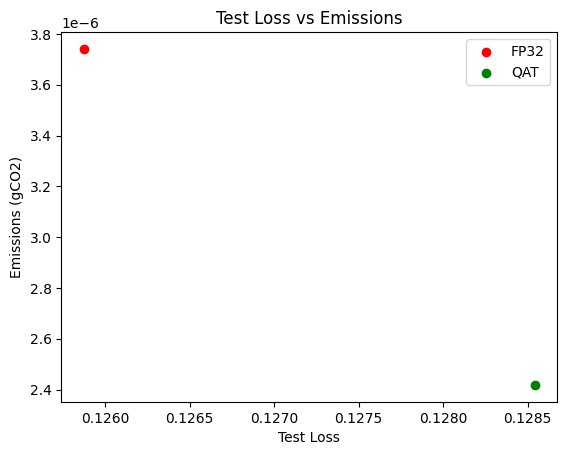

In [ ]:
plt.scatter(test_loss, inf_emissions, label="FP32", color="red")

plt.scatter(test_loss_qat, qat_inf_emissions, label="QAT", color="green")

plt.xlabel("Test Loss")
plt.ylabel("Emissions (gCO2)")
plt.legend()
plt.title("Test Loss vs Emissions")
plt.show()

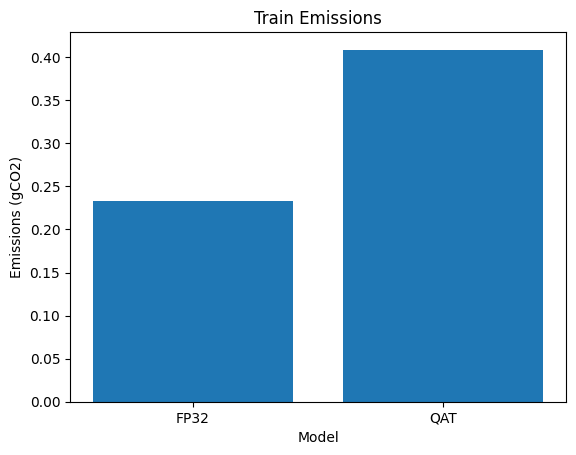

In [ ]:
# barplot train emissions
models = ["FP32", "QAT"]
emissions = [train_emissions, qat_train_emissions]

plt.bar(models, emissions)

plt.xlabel("Model")
plt.ylabel("Emissions (gCO2)")

plt.title("Train Emissions")

plt.show()

# Comparaison des tailles des modèles

In [ ]:
def get_model_size(model):
    torch.save(model.state_dict(), "model.pth")
    size = os.path.getsize("model.pth")
    os.remove("model.pth")
    return size

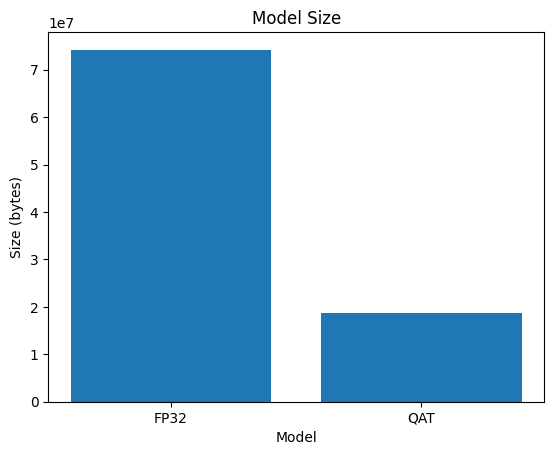

In [ ]:
models = ["FP32", "QAT"]
sizes = [get_model_size(model), get_model_size(qat_model)]

plt.bar(models, sizes)

plt.xlabel("Model")
plt.ylabel("Size (bytes)")

plt.title("Model Size")

plt.show()

# Comparaison avec la Post-Training-Quantization

In [ ]:
def calibrate_model(model, train_loader, n_iter: int = 5):
    model.eval()
    with torch.no_grad():
        for _ in range(n_iter):
            for i, (X_batch, y_batch) in enumerate(train_loader):
                model(X_batch.float())

In [ ]:
ptq_model = QuantizedModel(model)

ptq_model.qconfig = torch.quantization.get_default_qconfig("fbgemm")

ptq_model = torch.quantization.prepare(ptq_model, inplace=True)

calibrate_model(ptq_model, trainloader, n_iter=5)

ptq_model = torch.quantization.convert(ptq_model, inplace=True)

test_loss_ptq, ptq_inf_emissions = evaluate(
    ptq_model, testloader, carbon_track=True, n_iter=5
)

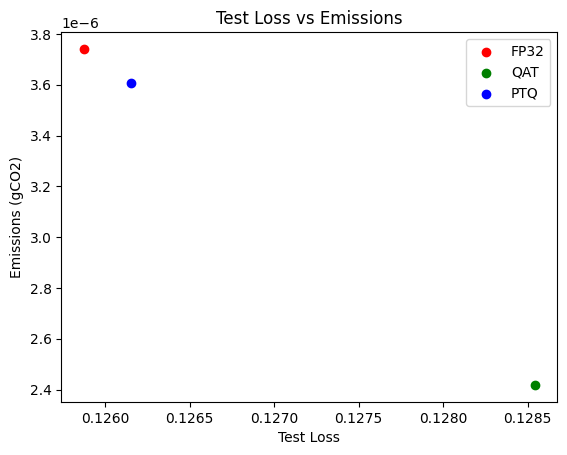

In [ ]:
# scatter plot
plt.scatter(test_loss, inf_emissions, label="FP32", color="red")
plt.scatter(test_loss_qat, qat_inf_emissions, label="QAT", color="green")
plt.scatter(test_loss_ptq, ptq_inf_emissions, label="PTQ", color="blue")

plt.xlabel("Test Loss")
plt.ylabel("Emissions (gCO2)")

plt.legend()
plt.title("Test Loss vs Emissions")

plt.show()

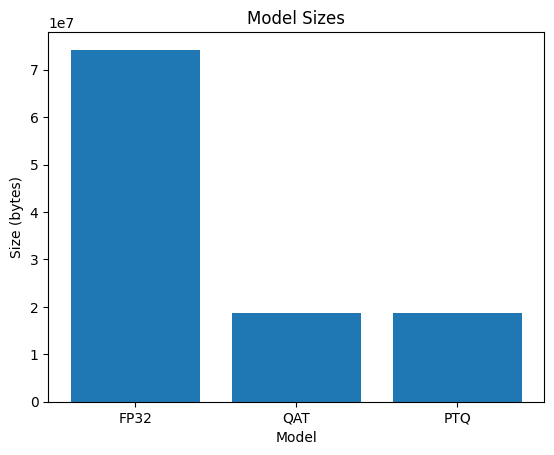

In [ ]:
# barplot model sizes
models = ["FP32", "QAT", "PTQ"]
sizes = [get_model_size(model), get_model_size(qat_model), get_model_size(ptq_model)]

plt.bar(models, sizes)

plt.xlabel("Model")
plt.ylabel("Size (bytes)")

plt.title("Model Sizes")

plt.show()

# Exemple avec la librairie *green_ai Made by Octo*

In [ ]:
from green_ai.experimentation import torch_Experimentation
from green_ai.models import torch_NN
from green_ai.models import torch_QATModel

log_file = "logs/GREAI.csv"
log_id = "QAT"

In [ ]:
model = torch_NN(
    input_size=input_size, hidden_sizes=hidden_layers, output_size=output_size
)
qat_model = torch_QATModel(base_model=copy.deepcopy(model), qconfig="fbgemm")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
qat_optimizer = torch.optim.Adam(qat_model.parameters(), lr=0.001)

criterion = torch.nn.L1Loss()

experiment = torch_Experimentation(
    models=[model, qat_model],
    model_names=["FP32", "QAT"],
    optimizers=[optimizer, qat_optimizer],
    loss_fn=criterion,
    train_loader=trainloader,
    validation_set=True,
    validation_size=0.2,
    test_loader=testloader,
    epochs=epochs,
    log_file=log_file,
    log_id=log_id,
    patience=3,
    metric_fn=torch.nn.L1Loss(),
)

In [ ]:
experiment.run_experiment()

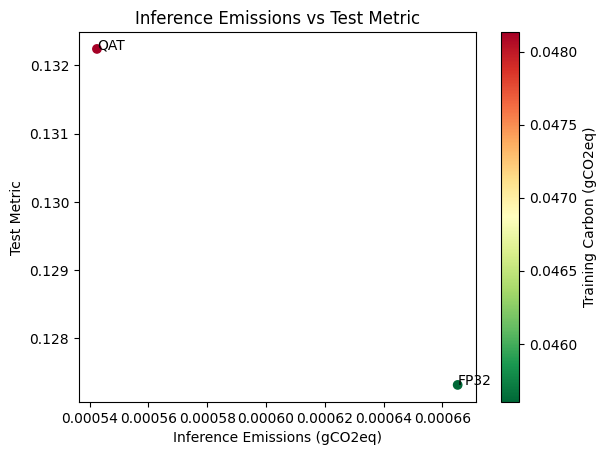

In [ ]:
experiment.plot_inference_vs_score(option="carbon")

In [ ]:
experiment.print_results()

  Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss     Test Metric  \
0  FP32       92.239097               0.045603   0.127320  tensor(0.1273)   
1   QAT       93.117796               0.048134   0.132243  tensor(0.1322)   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       0.424516                   0.000665  
1                       0.395634                   0.000543  


Model  Train Time (s)  Train Carbon (gCO2eq)  Test Loss     Test Metric  \
0  FP32       92.239097               0.045603   0.127320  tensor(0.1273)   
1   QAT       93.117796               0.048134   0.132243  tensor(0.1322)   

   Inference Time (1000 samples)  Inference Carbon (gCO2eq)  
0                       0.424516                   0.000665  
1                       0.395634                   0.000543